# 토픽모델링을 통한 키워드 분석

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 사용할 라이브러리/데이터 불러오기 

In [2]:
!pip install konlpy pecab gensim
!curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ hash mecab
+ echo 'mecab-ko is already installed'
mecab-ko is already installed
+ [[ -d /usr/local/lib/mecab/dic/mecab-ko-dic ]]
+ echo 'mecab-ko-dic is already installed'
mecab-ko-dic is already installed
++ python3 -c 'import pkgutil; print(1 if pkgutil.find_loader("MeCab") else 0)'
+ [[ 1 == \1 ]]
+ echo 'mecab-python is already installed'
mecab-python is already installed
+ echo Done.
Done.


In [3]:
import sys
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm  # progress bar
from konlpy.tag import Mecab; mecab = Mecab()
from konlpy.tag import Komoran; komoran = Komoran()

import numpy as np
import pandas as pd
import string
import re
import warnings
from gensim import corpora
from gensim import models
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

## 운영체제별 글꼴 세팅

# 그래프를 이쁘게 그리기 위한 코드입니다. 한글 글꼴을 추가합니다.

%matplotlib inline  

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
import seaborn as sns
mpl.rcParams['axes.unicode_minus'] = False

sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")
print(sys_font)

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져옵니다.
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

sys_font number: 48
['/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoEco.ttf', '/usr/share/fonts/truetype/nanum/NanumBrush.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareEB.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicCoding-Bold.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundL.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunpenR.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoExtraBold.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothicUltraLight.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', '/usr/sh

In [4]:
# Colab Notebooks

## 크롤링한 파일이 바뀌면, 경로도 수정되어야 합니다.
data_path = '/content/drive/MyDrive/Colab Notebooks/data/topic/갤럭시_(2022.01.01~2022.12.06).xlsx'

In [6]:
import pandas as pd

documents = pd.read_excel(data_path)['contents'].dropna() # 빈 문서 제거.
documents

0       언론인 출신 백수현, 박승희 부사장도 나란히 승진    ▲ 삼성전자 이영희 사장\t...
1       이영희 DX부문 글로벌마케팅실장 사장  삼성전자가 5일 네트워크와 반도체 사업의 성...
2       삼성 새 역사 쓴 이영희 사장마케팅 전문가로 2007년 영입유니레버·SC존슨·로레알...
3       이영희 삼성전자 DX부문 글로벌마케팅센터장. 연합뉴스삼성에서 오너가 출신이 아닌 첫...
4       비오너가 출신 이영희 삼성전자 사장…2012년 부사장 승진 이후 10년 만2007년...
                              ...                        
2717    이통3사 '갤S22' 공시지원금 5.3만~24만원…전작 대비 절반 수준실구매자는 2...
2718    갤럭시 S20·노트10·노트9 15만 원 추가 보상    전국 대형마트 및 통신사 ...
2719    [이데일리 전재욱 기자] 온라인 장보기 업체 마켓컬리는 삼성전자 신작 스마트폰 ‘갤...
2720    이통3사 '갤S22' 공시지원금 5.3만~24만원…전작 대비 절반 수준실구매자는 2...
2721    갤럭시 S20·노트10·노트9 15만 원 추가 보상    전국 대형마트 및 통신사 ...
Name: contents, Length: 2722, dtype: object

## 2. 전처리 함수 정의하기 

In [7]:
def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 패턴.
    #doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    
    # 특수문자를 제거하는 패턴.
    doc = re.sub("[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"]", " ", doc)
    
    # 영문 빼고 모두 제거하는 패턴.
    #doc = doc.replace("\n", " ")
    #doc = re.sub("[^A-Za-z ]", "", doc)
    
    return doc

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    SW.add("있어요")
    
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding="utf-8") as f:
        for word in f:
            SW.add(word.strip())
            
    return SW

def text_tokenizing(doc, tokenizer):
    """
    Input Parameter :
    
    doc - tokenizing 하는 실제 데이터.
    tokenizer - token의 단위.
    """
    # 불용어(SW)에 포함되어 있지 않고, 두 글자 이상인 token(형태소)만 사용하겠다.
    
    if tokenizer == "words":
        return [token for token in doc.split() if (token not in SW) and (len(token) >= 2)]
    
    elif tokenizer == "nouns":
        return [token for token in mecab.nouns(doc) if (token not in SW) and (len(token) >= 2)] # 주어진 텍스트에서 명사만 뽑아서 리스트로 반환.
        
    elif tokenizer == "morphs":
        return [token for token in mecab.morphs(doc) if (token not in SW) and (len(token) >= 2)] # 주어진 텍스트에서 형태소 단위로 잘라서 리스트로 반환.

In [8]:
tokenizer = 'nouns'
SW = define_stopwords('/content/drive/MyDrive/Colab Notebooks/data/topic/stopwords-ko.txt')
tokenized_documents = [text_tokenizing(text_cleaning(doc), tokenizer=tokenizer) for doc in documents]

In [9]:
print(len(tokenized_documents))
print(tokenized_documents[0])

2722
['언론인', '출신', '백수현', '박승희', '부사장', '승진', '삼성전자', '이영희', '사장', '삼성전자', '이영희', '부사장', '사장', '승진', '사장', '승진', '인사', '단행', '삼성', '오너', '일가', '여성', '사장', '처음', '이영희', '사장', '그동안', '삼성전자', '최초', '여성', '사장', '후보', '거론', '유니레버', '로레알', '출신', '마케팅', '전문가', '삼성전자', '마케팅', '담당', '임원', '발탁', '부사장', '승진', '부사', '장직', '유지', '신임', '사장', '갤럭시', '시리즈', '마케팅', '성공', '삼성전자', '글로벌', '브랜드', '인지도', '기여', '평가', '삼성', '역량', '성과', '여성', '부사장', '사장', '승진', '여성', '인재', '성장', '비전', '제시', '도전', '계기', '마련', '이재용', '삼성전자', '회장', '평소', '성별', '국적', '불문', '세상', '인재', '양성', '강조', '회장', '취임', '현실', '시장', '대응', '기회', '준비', '실력', '창업', '중시', '가치', '인재', '기술', '성별', '국적', '불문', '세상', '인재', '양성', '세상', '기술', '투자', '사장', '승진', '명단', '삼성전자', '부문', '네트워크', '사업', '전략', '마케팅', '팀장', '김우준', '부사장', '삼성전자', '부문', '네트워크', '사업', '부장', '사장', '삼성전자', '부문', '글로벌', '마케팅', '센터', '이영희', '부사장', '삼성전자', '부문', '글로벌', '마케팅', '실장', '사장', '삼성전자', '부문', '글로벌', '제조', '인프라', '총괄', '남석우', '부사장', '삼성전자', '글로벌', '제조', '인프라', '총괄', '제조', '담당', '사장

### gensim LDA model을 사용하기 위한 자료구조 생성. 

In [10]:
# 문서-단어 행렬 만들기
# 어휘(vocabulary) 학습
dictionary = corpora.Dictionary(tokenized_documents)
# 문서-단어 행렬 생성
corpus = [dictionary.doc2bow(document) for document in tokenized_documents]

In [11]:
NUM_TOTAL_WORDS = len(dictionary)
print(dictionary)
print(NUM_TOTAL_WORDS)

Dictionary(7473 unique tokens: ['가치', '강조', '갤럭시', '거론', '건설']...)
7473


## 3. 토픽 모델링(LDA Model)


- LDA(Latent Dirichlet Allocation) : 단어들의 조합(토픽)이 하나의 토픽을 구성하고, 각 단어가 그 토픽에 할당될 확률을 계산합니다.

- LDA는 사람이 글을 쓰는 과정을 다음과 같이 가정합니다.

1) 여러 개의 토픽을 정한다.

2) 토픽 하나를 고릅니다.

3) 토픽 내에 속하는 단어 하나를 고릅니다.

4) 해당 단어를 글에 적습니다.

5) 2번 과정부터 반복하면서 글을 적습니다.


-> LDA는 사람이 글을 쓰는 과정을 따라하면서 글을 생성하는 과정을 학습합니다. (Generative Model)

-> LDA는 생성을 통해서, 저자가 생각한 토픽의 분포(단어들의 확률 분포)를 찾습니다.

In [12]:
# ldamodel 선언
from gensim.models.ldamodel import LdaModel

# Coherence model 선언 (LDA의 정량 평가 지표.)
from gensim.models.coherencemodel import CoherenceModel

In [13]:
# 토픽 개수와 토픽 별 상위 추출 단어 개수 지정.

def build_doc_term_mat(documents):
    """주어진 문서 집합으로 문서-어휘 행렬을 만들어 돌려준다."""
    
    print_log_msg("Building document-term matrix.")
    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]

    return corpus, dictionary


def print_topic_words(model):
    """토픽별 토픽 단어들을 화면에 인쇄한다."""
    
    print_log_msg("Printing topic words.")
    
    for topic_id in range(model.num_topics):
        topic_word_probs = model.show_topic(topic_id, 30)
        print("Topic ID: {}".format(topic_id))

        for topic_word, prob in topic_word_probs:
            print("\t{}\t{}".format(topic_word, prob))

        print("\n")


def print_log_msg(msg):
    """로그 메시지를 출력한다."""
    
    print(msg, flush=True)

In [14]:
def compute_coherence(dictionary, corpus, texts, start, end, step):
    '''
    start, end+1, step에 해당하는 토픽 개수를 입력받아서 LdaModel을 수행하고, 그 때의 Coherence Score를 함께 돌려주는 함수.
    '''
    coherence_score_list = []
    model_list = []
    for num_topics in tqdm(range(start, end+1, step)):
        model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics, # 몇개의 토픽을 찾을건지
                         passes=10, # 학습 반복 횟수 (100 ~ 300)
                         random_state=42)
        
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
        coherence_score_list.append(coherence_model.get_coherence())
        
    return model_list, coherence_score_list

In [15]:
# LDA에서 가장 중요한 파라미터 = K(토픽 개수)
start, end, step = [int(x) for x in input("원하는 토픽 갯수들을 입력하세요(e.g. 2,5,1)").split(",")]
start, end, step

원하는 토픽 갯수들을 입력하세요(e.g. 2,5,1)2,6,1


(2, 6, 1)

In [16]:
corpus, dictionary = build_doc_term_mat(tokenized_documents)
print(len(corpus), len(dictionary))


model_list, coherence_scores = compute_coherence(dictionary=dictionary, corpus=corpus, 
                                                texts=tokenized_documents, start=start, end=end, step=step)

Building document-term matrix.
2722 7473


  0%|          | 0/5 [00:00<?, ?it/s]

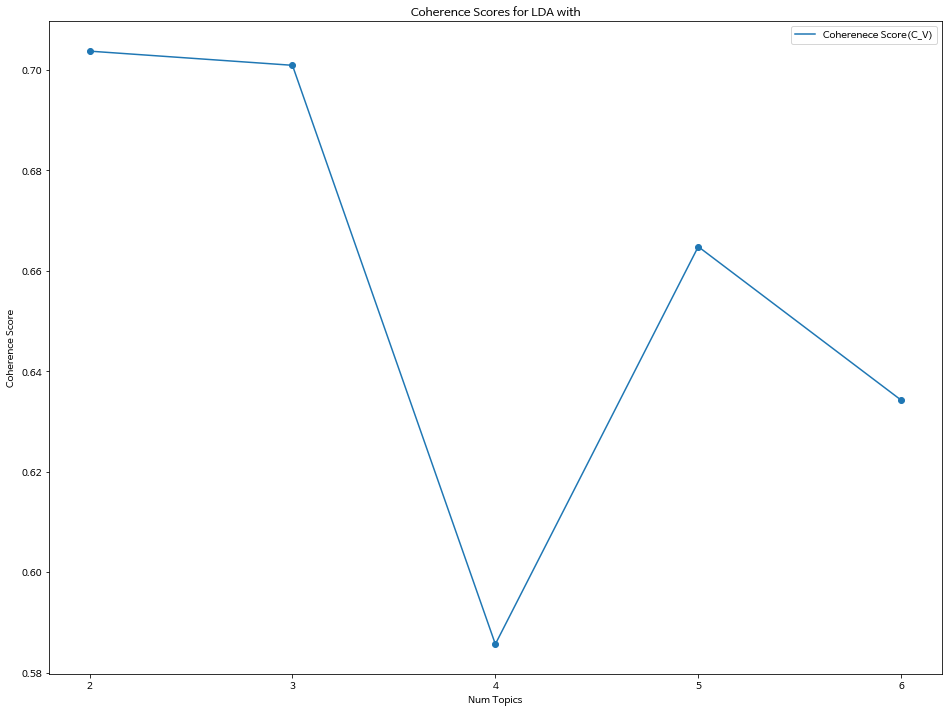

In [17]:
coherence_list = coherence_scores
label = "Coherenece Score(C_V)"

x = range(start, end+1, step)
plt.figure(figsize=(16, 12))
plt.xticks(x)
plt.plot(x, coherence_list, label=label)
plt.scatter(x, coherence_list)
plt.title(f"Coherence Scores for LDA with")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(loc='best')
plt.show()

In [18]:
selected_model = model_list[np.argmax(coherence_list)] # coherence score가 가장 높은 LDA model을 selected_model로 할당.
selected_model.num_topics

2

### 4. pyLDAvis를 이용한 시각화 

In [19]:
!pip install pyldavis==3.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 32.1 MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-3.2.1-py2.py3-none-any.whl size=136188 sha256=74b82e3d995d6ed43a3b728c38ba16ecb915a97283c9abd8d9ff1d4c4f5eec06
  Stored in directory: /root/.cache/pip/wheels/ae/5f/79/278ffb79ffde795f9686b558a8e313971ee0d3a914105d57dd
Successfully built pyldavis


In [20]:
# pyLDAvis 불러오기
import pyLDAvis
import pyLDAvis.gensim

# pyLDAvis를 jupyter notebook에서 실행할 수 있게 활성화.
pyLDAvis.enable_notebook()

# pyLDAvis 실행.
data = pyLDAvis.gensim.prepare(selected_model, corpus, dictionary)
data

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.211735  0.0       1        1  55.015994
0     -0.211735  0.0       2        1  44.984006, topic_info=     Term          Freq         Total Category  logprob  loglift
673    마켓   5922.000000   5922.000000  Default  30.0000  30.0000
7247   컬리   5900.000000   5900.000000  Default  29.0000  29.0000
2145   보상   7044.000000   7044.000000  Default  28.0000  28.0000
2     갤럭시  26915.000000  26915.000000  Default  27.0000  27.0000
418    노트   5286.000000   5286.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
51    시리즈   2220.802120   3715.123378   Topic2  -4.5281   0.2843
782    혜택   1675.723415   2695.132231   Topic2  -4.8098   0.3237
665    구매   1845.522904   6006.699776   Topic2  -4.7132  -0.3812
143    고객   1806.739895  10146.233260   Topic2  -4.7345  -0.9267
193    제공   1595.694502   5210.547780   Topic2  -4.8587  -0.3845

[148 rows x 6 columns], token_table=      Topic      Freq Term
term                      
662       1  0.000688   가격
662       2  0.999593   가격
335       1  0.983103   가능
335       2  0.016950   가능
704       1  0.999904   가입
...     ...       ...  ...
1275      2  0.002342   확대
522       1  0.999846   확인
522       2  0.000464   확인
2358      1  0.999026  휴대폰
2358      2  0.000904  휴대폰

[226 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])